In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
pickles = ['A.pickle', 'B.pickle', 'C.pickle', 'D.pickle', 'E.pickle', 'F.pickle', 'G.pickle', 'H.pickle']

In [3]:
df = pd.DataFrame()

useless = ['artist_id', 'artist_mbid', 'artist_playmeid', 'artist_7digitalid', 'release_7digitalid', 'song_id',
           'track_7digitalid', 'similar_artists', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight',
           'audio_md5', 'track_id', 'artist_mbtags', 'artist_mbtags_count', 'artist_name', 'release', 'artist_location'
          ]

almost_empty = ['artist_latitude', 'artist_longitude', 'danceability', 'energy', 'analysis_sample_rate']

mean_col = ['segments_confidence', 'sections_confidence', 'beats_confidence', 'bars_confidence', 'tatums_confidence']

mean_diff = ['sections_start', 'beats_start', 'bars_start', 'tatums_start']

length = ['title']

In [4]:
def feat_engineering(filename):
    print('processing:', filename)
    curr = pd.read_pickle(filename)
    curr = curr.drop(columns = useless)
    curr = curr.drop(columns = almost_empty)
    for c in mean_col:
        curr[c+'_mean'] = curr[c].apply( lambda x: 0 if len(x)==0 else np.mean(x) )
        curr[c+'_len'] = curr[c].apply( lambda x: len(x) )
    curr = curr.drop(columns = mean_col)
    for c in mean_diff:
        curr[c+'_mean_diff'] = curr[c].apply( lambda x: 0 if len(x)<2 else np.mean(np.array(x)[1:]-np.array(x)[:-1]) )
    curr = curr.drop(columns = mean_diff)
    for c in length:
        curr[c+'_length'] = curr[c].apply( lambda x: len(x) )
    curr = curr.drop(columns = length)
    curr['mode_modified'] = (curr['mode']*2-1) * curr['mode_confidence']
    curr = curr.drop(columns = ['mode', 'mode_confidence'])
    
    curr = curr[curr['segments_pitches'].apply(lambda x : len(x)) >=121]
    
    X = []
    for ind, row in curr[['segments_pitches', 'segments_timbre', 'segments_loudness_start', 'segments_loudness_max', 'segments_loudness_max_time', 'segments_start']].iterrows():
        if row['segments_pitches'].shape[0] >= 121:
            beg_ind = (row['segments_pitches'].shape[0]-121)//2
            pitch = row['segments_pitches'][beg_ind:beg_ind+120]
            timbre = row['segments_timbre'][beg_ind:beg_ind+120]
            loudness = row['segments_loudness_start'][beg_ind:beg_ind+120].reshape(-1, 1)
            loudness_max = row['segments_loudness_max'][beg_ind:beg_ind+120].reshape(-1, 1)
            loudness_max_time = row['segments_loudness_max_time'][beg_ind:beg_ind+120].reshape(-1, 1)
            duration = (row['segments_start'][beg_ind+1:beg_ind+121]-row['segments_start'][beg_ind:beg_ind+120]).reshape(-1, 1)
            X.append( np.concatenate((pitch, timbre, loudness, loudness_max, loudness_max_time, duration), axis=1) )
    curr['audio_data'] = X
    curr = curr.drop(columns = ['segments_start','segments_pitches','segments_timbre','segments_loudness_max','segments_loudness_max_time','segments_loudness_start'])
    
    mean_year = sum(curr['year']) / sum(curr['year']!=0)
    curr['year'] = curr['year'].apply(lambda x: mean_year if x==0 else x)
    return curr

In [5]:
for p in pickles:
    df = pd.concat([df, feat_engineering(p)])

processing: A.pickle
processing: B.pickle
processing: C.pickle
processing: D.pickle
processing: E.pickle
processing: F.pickle
processing: G.pickle
processing: H.pickle


In [6]:
df_norm = df.copy()

print(df_norm['artist_hotttnesss'])

0        0.461318
1        0.386606
2        0.401998
3        0.307080
7        0.387617
8        0.336660
10       0.000000
13       0.342480
14       0.378545
15       0.401724
22       0.445716
24       0.542884
28       0.562610
37       0.336491
41       0.398984
42       0.332276
44       0.414283
48       0.296269
49       0.401116
52       0.392368
55       0.351556
56       0.379482
57       0.444632
58       0.381501
59       0.447142
62       0.479770
63       0.328403
64       0.382038
65       0.305295
66       0.501825
           ...   
38465    0.590292
38466    0.353942
38467    0.379735
38469    0.362903
38470    0.531775
38472    0.374065
38475    0.301122
38479    0.400251
38480    0.272103
38481    0.270230
38483    0.353884
38485    0.210433
38486    0.458982
38488    0.411259
38489    0.396810
38493    0.383392
38497    0.354472
38499    0.504924
38501    0.255267
38502    0.530784
38503    0.444087
38505    0.516193
38506    0.477179
38507    0.463032
38509    0

In [7]:
def norm_column(x):
    return (np.array(x) - np.mean(x))/np.std(x)

#print(df['analysis_sample_rate'])
for c in df_norm.columns:
    #print(c, np.std(df_norm[c]))
    if c != 'audio_data' and c != 'song_hotttnesss':
        df_norm[c] = norm_column(df_norm[c])

print(df_norm['artist_hotttnesss'])

0        0.553462
1       -0.108783
2        0.027644
3       -0.813702
7       -0.099826
8       -0.551511
10      -3.535656
13      -0.499916
14      -0.180242
15       0.025216
22       0.415167
24       1.276457
28       1.451314
37      -0.553008
41       0.000935
42      -0.590369
44       0.136545
48      -0.909533
49       0.019830
52      -0.057709
55      -0.419471
56      -0.171932
57       0.405558
58      -0.154039
59       0.427804
62       0.717019
63      -0.624700
64      -0.149273
65      -0.829527
66       0.912509
           ...   
38465    1.696687
38466   -0.398316
38467   -0.169691
38469   -0.318890
38470    1.177989
38472   -0.219953
38475   -0.866515
38479    0.012164
38480   -1.123744
38481   -1.140344
38483   -0.398830
38485   -1.670382
38486    0.532750
38488    0.109736
38489   -0.018341
38493   -0.137274
38497   -0.393620
38499    0.939981
38501   -1.272977
38502    1.169207
38503    0.400722
38505    1.039874
38506    0.694050
38507    0.568654
38509   -0

In [8]:
ad = np.concatenate( df_norm['audio_data'].apply(lambda x : x.reshape(1, 120, 28)).values )
mean = [ad[:, :, :12].mean(), ad[:, :, 12:24].mean(), ad[:, :, 24].mean(), ad[:, :, 25].mean(), ad[:, :, 26].mean(), ad[:, :, 27].mean()]
std = [ad[:, :, :12].std(), ad[:, :, 12:24].std(), ad[:, :, 24].std(), ad[:, :, 25].std(), ad[:, :, 26].std(), ad[:, :, 27].std()]

ad[:, :, :12] = ( ad[:, :, :12] - mean[0] ) / std[0]
ad[:, :, 12:24] = ( ad[:, :, 12:24] - mean[1] ) / std[1]
ad[:, :, 24] = ( ad[:, :, 24] - mean[2] ) / std[2]
ad[:, :, 25] = ( ad[:, :, 25] - mean[3] ) / std[3]
ad[:, :, 26] = ( ad[:, :, 26] - mean[4] ) / std[4]
ad[:, :, 27] = ( ad[:, :, 27] - mean[5] ) / std[5]

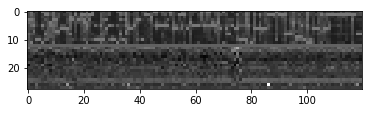

In [9]:
df_norm['audio_data'] = list(ad)

plt.imshow(df_norm['audio_data'].values[0].T, cmap='gray')

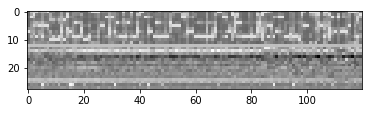

In [10]:
plt.imshow(df_norm['audio_data'].values[9].T, cmap='gray')

In [11]:
df_norm.to_pickle('norm_all_data.pickle')